In [2]:
!pip install casadi

import sys
sys.path.insert(0, '../python/casadi_f16')
import f16
import control
import numpy as np
import matplotlib.pyplot as plt
from analysis import loop_analysis

# Roll Autopilot Design

* See Roll Autopilot design example in section 4.6 of Stevens and Lewis.
* Homework 1: Due 8/30 @  11 pm: Trim the F16 model around a VT=550 ft/s, 20 deg/s yaw rate turn.
* Find the A, B, C, D matrices for the state space model.
* Find the transfer function for the aileron to roll rate (P).
* Design a PID controller attempting to meet the following specifications
    * Maximum overshoot: 20%
    * Rise time: 0.1 second
    * Settling time 1 second
* Simulate and plot the response of your controlled system and the linear model for a step response in roll rate of 10 deg/s and 100 deg/s. How do the nonlinear and linear responses compare?
* Using git, fork aae497-f16 on github. Complete the homework. Submit your homework via pull request on aae497-f16.

## Definitions

In [9]:
# Trimming f16
p = f16.Parameters()
x0, u0 = f16.trim(x=f16.State(
    VT=550), p=p,
    phi_dot=0, theta_dot=0, psi_dot=np.radians(20), gam=0);

# Control Function
f_control = lambda t, x: f16.Control(thtl=u0.thtl, ail_deg=u0.ail_deg, elv_deg=u0.elv_deg, rdr_deg=u0.rdr_deg)

## Simulation

In [13]:
#def select(n, i):
#    D = np.zeros((1, n))
#    D[0, i] = 1
#    return control.ss([], [], [], D)

ss = f16.linearize(x0, u0, p)

s = f16.linearize(x0, u0, p)
s = control.tf([1, 0], [0, 1])
G = 180/np.pi*ss.sub_system(x=['alpha', 'Q'],
                  u=['elv_deg'], y=['alpha', 'Q']).to_control()

# represents elevator motor
sysa = -20.2/(s + 20.2) # actuator and sign change

sys1 = G*sysa # output is on left, input on right, so plant*actuator
sysf = control.ss(-10, [10, 0], [[1], [0]], [[0, 0], [0, 1]])  # aoa low-pass filter
sys2 = sysf*sys1

# closed inner loop
Kalpha = 0.2 # inner aoa gain
sys3 = control.ss(sys2.A - sys2.B*[Kalpha, 0]*sys2.C, sys2.B, sys2.C, sys2.D)

sysi = (s+3)/s # PI controller
sys4 = sys3[1, 0]*sysi

# outputs
print('The State Space Model is:\n',G)

KeyError: 'elv_deg'

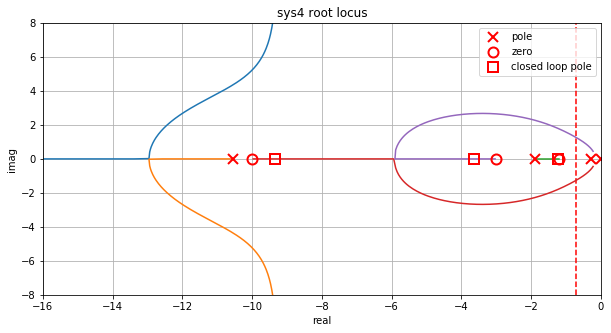

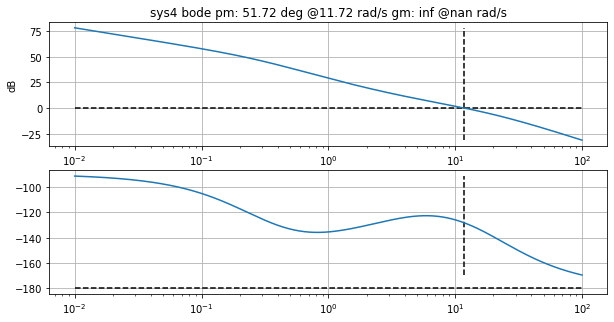

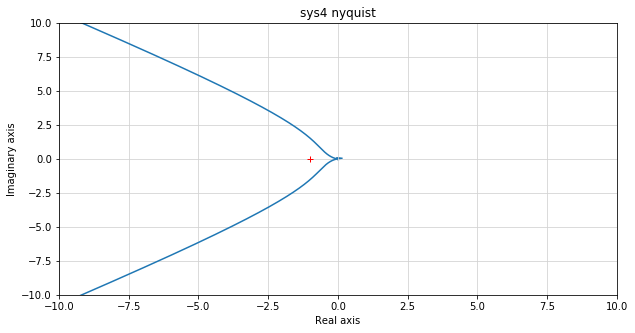

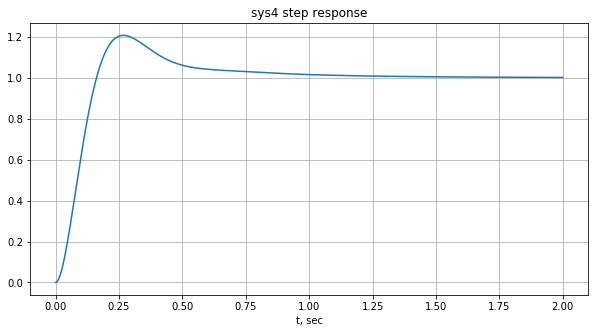

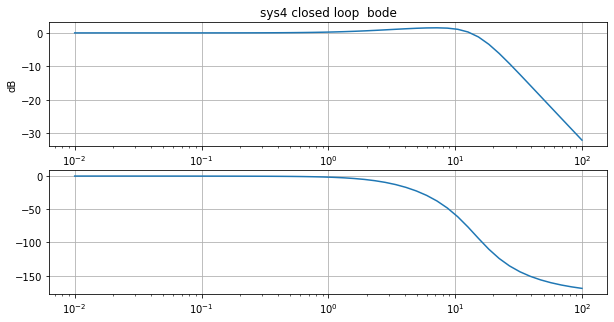

In [7]:
loop_analysis('sys4', (s+3)/s*sys3[1, 0], zeta=np.sqrt(2), wd=3, k=0.9, t_vect=np.linspace(0, 2, 1000), k_vect=np.logspace(-2, 1, 1000),
              omega_vect=np.logspace(-2, 2, 1000))

In [14]:
P = 1
I = 1
D = 0
H_PI = P + I * (1/ s) + D
print(H_PI)

G0 = H_PI*sys3[1, 0]
print(G0)

Gc = control.feedback(G0, 1)


s + 1
-----
  s



NameError: name 'sys3' is not defined

In [ ]:
t, y = control.step_response(Gc, T=np.linspace(0, 1, 1000))
plt.figure(figsize=(10, 5))
plt.plot(t, 1*y)
plt.grid()
plt.show()
print(max(y))